<a href="https://colab.research.google.com/github/avkornaev/Fast_AI_course/blob/main/XRayImagesAnalysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#hide
!pip install -Uqq fastbook
import fastbook
#fastbook.setup_book()

Connect to Google disk.

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Import libraries. Connect to Google disk.

In [3]:
import numpy as np
import pandas as pd
from fastbook import *
from fastai.data.all import *
from fastai.vision.all import *
from fastai.vision.widgets import *

Path.


In [4]:
dataPath = Path('/content/drive/MyDrive/Covid_detection_Kaggle_summer_2021/')
imdsFolder = 'images'
#print(os.getcwd()) # current directory

Settings.

In [5]:
initImSize = 1024
reqImSize = 224
cropRatio = reqImSize/initImSize

Create list of classes.

In [6]:
classes = ['0 - Negative','1 - Typical','2 - Indeterminate','3 - Atypical']
n = len(classes)
print(os.getcwd()) # current directory
print(os.listdir('/content')) # and it's content

/content
['.config', 'drive', 'sample_data']


In [7]:
import json
with open(dataPath/"targets.json", "r") as f:
    targets = json.load(f)
#print(targets)

Check an image information.

In [8]:
image_id = '000a312787f2'
print('study level (class number): ', targets[image_id]['study_level'])
print('image level (bounding boxes): ', targets[image_id]['image_level'])
print('metadata (additional info from the DICOM image file): ', targets[image_id]['metadata'])

study level (class number):  1
image level (bounding boxes):  {'boxes': [[0.18545309210526317, 0.16698117832568807, 0.42667880169172934, 0.7166666485091744], [0.5277049060150376, 0.16949692660550458, 0.7849092340225564, 0.6745283027522936]], 'labels': [1, 1], 'image_id': '000a312787f2', 'iscrowd': [0, 0], 'area': [6653.2506748157, 6517.674527234884]}
metadata (additional info from the DICOM image file):  [0.1976, 0.35119999999999996, 0.5, -0.44066666666666665, -0.16366666666666668, 0.5, 0.0, 0.0, -0.75, -0.5, -0.5, -0.4166666666666667]


Create data frame.

In [9]:
targetsDFa = pd.DataFrame(targets) # auxiliary dataFrame
targetsDF = np.array([list(targetsDFa.columns+'.png'), list(targetsDFa.loc['study_level'].values)])
targetsDF = pd.DataFrame(targetsDF.T, columns = ['file_name', 'label'])

In [10]:
targetsDF.head()

,file_name,label
0,65761e66de9f.png,1
1,51759b5579bc.png,3
2,f6293b1c49e2.png,0
3,3019399c31f4.png,0
4,bb4b1da810f3.png,3


In [11]:
targetsDF.values.shape

(6331, 2)

Download and import of X-ray images.

https://docs.fast.ai/tutorial.medical_imaging.html#Download-and-import-of-X-ray-DICOM-files

https://docs.fast.ai/vision.data.html#ImageDataLoaders.from_df

https://colab.research.google.com/github/fastai/fastbook/blob/master/02_production.ipynb#scrollTo=vP4nen7N383Q

In [12]:
#images_source = untar_data()
xray = ImageDataLoaders.from_df(targetsDF, path=dataPath/imdsFolder, valid_pct=0.2,
                                seed=42, fn_col=0, folder=None, 
                                suff='', label_col=1, label_delim=None, 
                                y_block=None, valid_col=None, item_tfms=Resize(224), 
                                batch_tfms=None, bs=64, val_bs=None, 
                                shuffle=None, device=None)
# item_tfms=Resize(128)

In [13]:
xray.dataloaders

<bound method FilteredBase.dataloaders of (#5065) [(PILImage mode=RGB size=1024x1024, TensorCategory(2)),(PILImage mode=RGB size=1024x1024, TensorCategory(1)),(PILImage mode=RGB size=1024x1024, TensorCategory(1)),(PILImage mode=RGB size=1024x1024, TensorCategory(1)),(PILImage mode=RGB size=1024x1024, TensorCategory(1)),(PILImage mode=RGB size=1024x1024, TensorCategory(1)),(PILImage mode=RGB size=1024x1024, TensorCategory(0)),(PILImage mode=RGB size=1024x1024, TensorCategory(1)),(PILImage mode=RGB size=1024x1024, TensorCategory(1)),(PILImage mode=RGB size=1024x1024, TensorCategory(2))...]>

Check images (optional).

In [14]:
#hide
fns = get_image_files(dataPath/imdsFolder)
#failed = verify_images(fns)
#print(failed)
#failed.map(Path.unlink);

Visualise a batch of images.

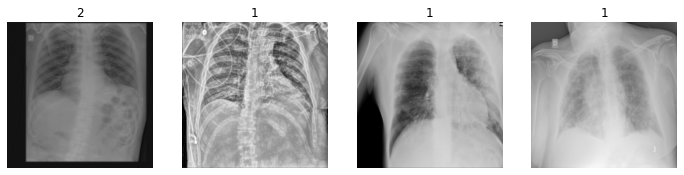

In [15]:
xray.show_batch(max_n=4, nrows=1)

Crop and augment images.

In [16]:
cropRatio

0.21875

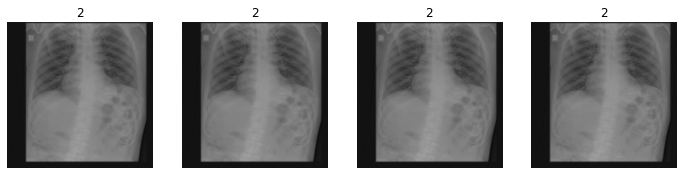

In [17]:
xray = xray.new(item_tfms=Resize(224),
                batch_tfms=aug_transforms())
xray.show_batch(max_n=4, nrows=1, unique=True)
#item_tfms=RandomResizedCrop(reqImSize, min_scale=cropRatio)

In [18]:
xray.dataloaders

<bound method FilteredBase.dataloaders of (#5065) [(PILImage mode=RGB size=1024x1024, TensorCategory(2)),(PILImage mode=RGB size=1024x1024, TensorCategory(1)),(PILImage mode=RGB size=1024x1024, TensorCategory(1)),(PILImage mode=RGB size=1024x1024, TensorCategory(1)),(PILImage mode=RGB size=1024x1024, TensorCategory(1)),(PILImage mode=RGB size=1024x1024, TensorCategory(1)),(PILImage mode=RGB size=1024x1024, TensorCategory(0)),(PILImage mode=RGB size=1024x1024, TensorCategory(1)),(PILImage mode=RGB size=1024x1024, TensorCategory(1)),(PILImage mode=RGB size=1024x1024, TensorCategory(2))...]>

In [19]:
#xray = xray.new(item_tfms=Resize(128), batch_tfms=aug_transforms(mult=2))
#xray.show_batch(max_n=4, nrows=1, unique=True)

In [20]:
learn = cnn_learner(xray, resnet18, metrics=error_rate)
learn.fine_tune(2)

AttributeError: ignored

References

[1] https://docs.fast.ai/tutorial.medical_imaging.html#Download-and-import-of-X-ray-DICOM-files